In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [100]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import gaussian_kde
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [ ]:
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')

In [ ]:
columns_to_convert = ['hypertension', 'heart_disease', 'stroke']
df[columns_to_convert] = df[columns_to_convert].astype(str)

In [ ]:
df.drop('id', axis= 1, inplace= True)

In [ ]:
df.drop(df.loc[df['gender'] == 'Other'].index, inplace= True)

Конвертируем целевой признак в int

In [ ]:
df['stroke'] = df['stroke'].map({'0': 0, '1': 1})

In [ ]:
X = df.drop('stroke', axis=1)
y = df['stroke']

In [ ]:
columns_to_convert = ['hypertension', 'heart_disease', 'stroke']
df[columns_to_convert] = df[columns_to_convert].astype(str)

In [ ]:
categorical_pipeline = Pipeline(
    steps=[
        ("onehot-encoder", OneHotEncoder(handle_unknown="ignore", sparse=False,drop='first')),
    ]
)

In [ ]:
numeric_pipeline = Pipeline(
    steps=[
           ("imputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
           ("scaler", StandardScaler())
         ]
)

In [ ]:
cat_features = df.select_dtypes(exclude="number").columns
num_cols = df.select_dtypes(include="number").columns
cat_cols = cat_features[:-1]

In [ ]:
full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [ ]:
X_processed = full_processor.fit_transform(X)
y_processed = y.values.reshape(-1,1)
print('X Shape: ', X_processed.shape)
print('y shape: ', y_processed.shape)

X Shape:  (5109, 15)
y shape:  (5109, 1)


Воспользуемся RandomOverSampler для борьбы с несбалансированностью классов

In [ ]:
ros = RandomOverSampler(sampling_strategy='minority')

X_sample, y_sample = ros.fit_resample(X_processed, y_processed)
print('Original Y Count: ', np.unique(y_processed, return_counts=True))
print('OverSample Y Count: ', np.unique(y_sample, return_counts=True))

Original Y Count:  (array([0, 1]), array([4860,  249]))
OverSample Y Count:  (array([0, 1]), array([4860, 4860]))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size = 0.3, stratify = y_sample, random_state = 2022)

In [ ]:
def draw_scores(model, data, labels):
    pred = model.predict(data)
    print('Accuracy:', accuracy_score(labels, pred))
    print('Precision:', precision_score(labels, pred))
    print('Recall:', recall_score(labels, pred))
    figure = plt.figure(figsize=(12, 4))
    matrix = confusion_matrix(labels, pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matrix).plot(ax=ax, cmap='Blues')
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(labels, pred, ax=ax)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

# LogisticRegression

## Своя реализация

In [ ]:
class My_LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                pred = self.sigmoid(np.dot(self.w, data_batch.T))
                grad = 2 * self.alpha * self.w + np.dot(pred - labels_batch, data_batch)
                
                self.w -= self.lr * grad
        return self
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict(self, data):
        return (self.sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) > 0.5).astype('int64')

In [109]:
random_lr = RandomizedSearchCV(Pipeline([('normalizer', Normalizer()), ('log', My_LogisticRegression())]),
                    {'log__lr': [0.1, 0.01, 0.001], 'log__epochs': [1, 10, 100], 
                     'log__batch': [10, 100, 1000], 'log__alpha': [0.01, 0.001, 0.0001]})
random_lr.fit(X_train, y_train)
print(random_lr.best_params_, random_lr.best_score_, sep='\n')

{'log__lr': 0.01, 'log__epochs': 10, 'log__batch': 10, 'log__alpha': 0.0001}
0.774248930284825


In [110]:
grid_lr = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('log', My_LogisticRegression())]),
                    {'log__lr': [0.1, 0.01, 0.001], 'log__epochs': [1, 10, 100], 
                     'log__batch': [10, 100, 1000], 'log__alpha': [0.01, 0.001, 0.0001]})
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_, grid_lr.best_score_, sep='\n')

{'log__alpha': 0.0001, 'log__batch': 10, 'log__epochs': 100, 'log__lr': 0.01}
0.7771870812983532


Accuracy: 0.7805212620027435
Precision: 0.7397420867526378
Recall: 0.8655692729766804


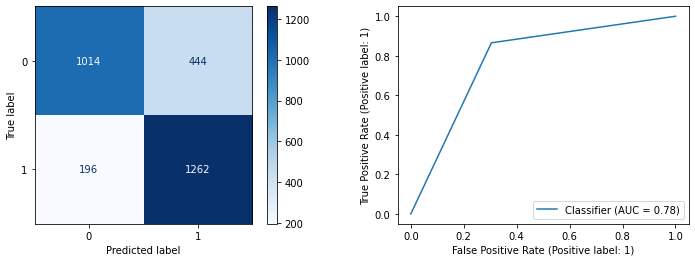

In [111]:
log = grid_lr.best_estimator_
draw_scores(log, X_test, y_test)

In [114]:
with open('log_regr.pkl', 'wb') as f:
    pickle.dump(log, f, pickle.HIGHEST_PROTOCOL)

## Готовый из sklearn

In [112]:
grid_lr_sk = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('log', SGDClassifier(loss='log', learning_rate='constant'))]),
                    {'log__eta0': [0.1, 0.01, 0.001], 'log__max_iter': [100, 1000, 5000], 
                     'log__alpha': [0.01, 0.001, 0.0001]})
grid_lr_sk.fit(X_train, y_train)
print(grid_lr_sk.best_params_, grid_lr_sk.best_score_, sep='\n')

{'log__alpha': 0.001, 'log__eta0': 0.01, 'log__max_iter': 1000}
0.7738071055020098


Accuracy: 0.7722908093278463
Precision: 0.7394451145958987
Recall: 0.840877914951989


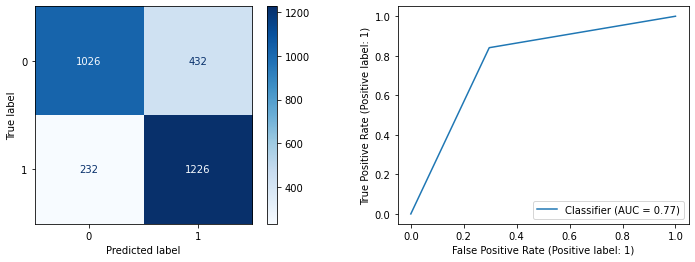

In [113]:
log_sk = grid_lr_sk.best_estimator_
draw_scores(log_sk, X_test, y_test)

# KNN

## Своя реализация

In [ ]:
class My_KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],))
        for i, x in enumerate(data):
            neighbors = np.argpartition(((self.data - data[i]) ** 2).sum(axis=1), self.k - 1)[:self.k]
            values, counts = np.unique(self.labels[neighbors], return_counts=True)
            res[i] = values[counts.argmax()]
        return res

In [ ]:
grid_knn = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('knn', My_KNN())]),
                    {'knn__k': [1, 5, 11, 15]})
grid_knn.fit(X_train, y_train)
print(grid_knn.best_params_, grid_knn.best_score_, sep='\n')

{'knn__k': 1}
0.962374551584043


Accuracy: 0.970164609053498
Precision: 0.9436893203883495
Recall: 1.0


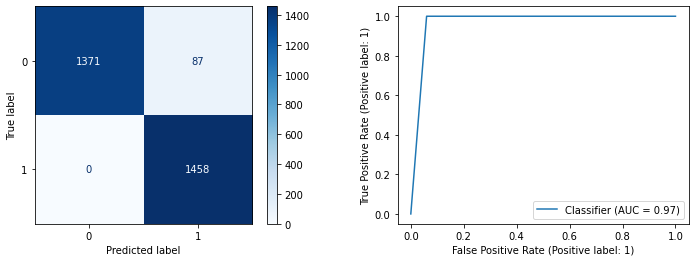

In [ ]:
knn = grid_knn.best_estimator_
draw_scores(knn, X_test, y_test)

In [86]:
with open('knn.pkl', 'wb') as f:
    pickle.dump(knn, f, pickle.HIGHEST_PROTOCOL)

## Готовый из sklearn

In [ ]:
grid_knn_sk = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
                    {'knn__n_neighbors': [1, 5, 11, 15]})
grid_knn_sk.fit(X_train, y_train)
print(grid_knn_sk.best_params_, grid_knn_sk.best_score_, sep='\n')

{'knn__n_neighbors': 1}
0.962374551584043


Accuracy: 0.970164609053498
Precision: 0.9436893203883495
Recall: 1.0


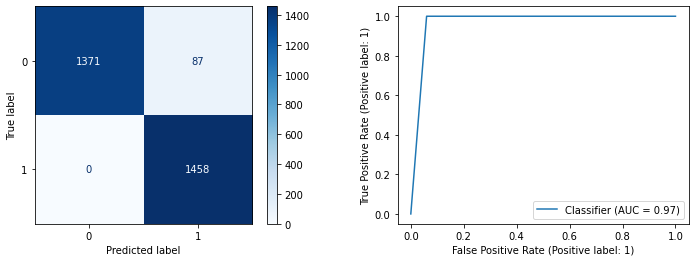

In [ ]:
knn_sk = grid_knn_sk.best_estimator_
draw_scores(knn_sk, X_test, y_test)

# Naive Bayes

## Своя реализация

In [106]:
class My_GaussianNB(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.means = []
        self.stds = []
        for c in np.unique(labels):
            self.means.append(data[labels == c,].mean(axis=0))
            self.stds.append(data[labels == c,].std(axis=0))
        self.classes = np.unique(labels, return_counts=True)[1] / len(labels)
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],))
        for i, obj in enumerate(data):
            prob = np.array(self.classes)
            for j in range(len(self.classes)):
                prob[j] *= np.cumprod(1 / self.stds[j] / np.sqrt(2 * np.pi) * np.exp(((obj - self.means[j]) / self.stds[j]) ** 2 / -2))[-1]
            res[i] = prob.argmax()
        return res

In [ ]:
gnb = Pipeline([('gauss bayes', My_GaussianNB())])
gnb.fit(X_train, y_train)
draw_scores(gnb, X_test, y_test)

In [108]:
with open('naive_bayes.pkl', 'wb') as f:
    pickle.dump(gnb, f, pickle.HIGHEST_PROTOCOL)

Accuracy: 0.6244855967078189
Precision: 0.5715976331360947
Recall: 0.9938271604938271


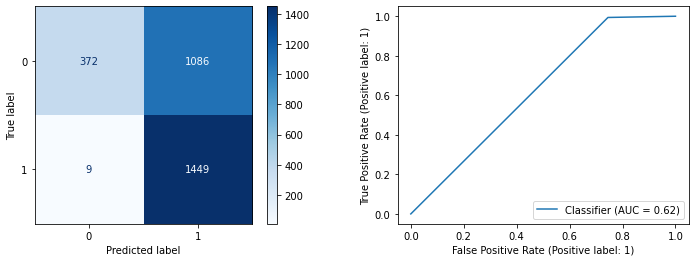

In [102]:
sk_gnb = GaussianNB()
sk_gnb.fit(X_train, y_train)
draw_scores(sk_gnb, X_test, y_test)

# SVM

## Своя реализация

In [ ]:
class My_SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        labels = labels * 2 - 1
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                grad = 2 * self.alpha * self.w
                for i, x in enumerate(data_batch):
                    if 1 - x.dot(self.w) * labels_batch[i] > 0:
                        grad -= x * labels_batch[i]
                
                self.w -= self.lr * grad
        return self

    def predict(self, data):
        return (np.sign(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) + 1) / 2

In [ ]:
random_svm = RandomizedSearchCV(Pipeline([('scaler', StandardScaler()), ('svm', My_SVM())]),
                    {'svm__lr': [0.1, 0.01, 0.001], 'svm__epochs': [1, 10, 100], 
                     'svm__batch': [10, 100, 1000], 'svm__alpha': [0.01, 0.001, 0.0001]})
random_svm.fit(X_train, y_train)
print(random_svm.best_params_, random_svm.best_score_, sep='\n')

{'svm__lr': 0.001, 'svm__epochs': 10, 'svm__batch': 10, 'svm__alpha': 0.01}
0.7657249211220124


In [ ]:
grid_svm = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('svm', My_SVM())]),
                    {'svm__lr': [0.1, 0.01, 0.001], 'svm__epochs': [1, 10, 100], 
                     'svm__batch': [10, 100, 1000], 'svm__alpha': [0.01, 0.001, 0.0001]})
grid_svm.fit(X_train, y_train)
print(grid_svm.best_params_, grid_svm.best_score_, sep='\n')

{'svm__alpha': 0.001, 'svm__batch': 1000, 'svm__epochs': 10, 'svm__lr': 0.001}
0.7708685222803302


Accuracy: 0.7746913580246914
Precision: 0.7559105431309904
Recall: 0.8113854595336076


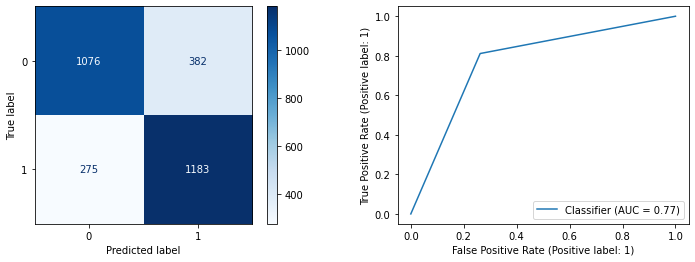

In [ ]:
svm = grid_svm.best_estimator_
draw_scores(svm, X_test, y_test)

In [87]:
with open('svm.pkl', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

## Готовый из sklearn

In [89]:
grid_svm_sk = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('svm', SGDClassifier(loss='hinge', learning_rate='constant'))]),
                    {'svm__eta0': [0.1, 0.01, 0.001], 'svm__max_iter': [100, 1000, 5000], 
                     'svm__alpha': [0.01, 0.001, 0.0001]})
grid_svm_sk.fit(X_train, y_train)
print(grid_svm_sk.best_params_, grid_svm_sk.best_score_, sep='\n')

{'svm__alpha': 0.001, 'svm__eta0': 0.01, 'svm__max_iter': 1000}
0.7707213554047628


Accuracy: 0.7781207133058985
Precision: 0.7229246838922485
Recall: 0.901920438957476


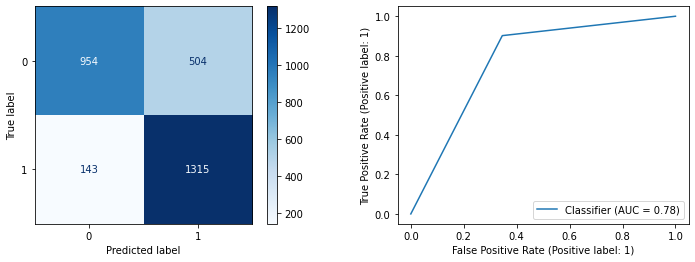

In [91]:
svm_sk = grid_svm_sk.best_estimator_
draw_scores(svm_sk, X_test, y_test)